# **Lab 4.2 NN MLP and CNN**

In [36]:
# %pip install tensorboard
%pip install tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [37]:
def load_data(path, class_names):
    ### START CODE HERE ###
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Pad(10),
            transforms.RandomRotation(45),
            transforms.CenterCrop(28),
            transforms.Grayscale(num_output_channels=1),
        ]
    )

    dataset = ImageFolder(path, transform=transform)

    # filter dataset by class names
    filtered_indices = [
        i
        for i, (_, label) in enumerate(dataset)
        if dataset.classes[label] in class_names
    ]
    filtered_dataset = Subset(dataset, filtered_indices)

    train_size = int(0.8 * len(filtered_dataset))
    test_size = len(filtered_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        filtered_dataset, [train_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    ### END CODE HERE ###

    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

In [38]:
def show_first_batch_image(data_loader):
    images, labels = next(iter(data_loader))

    images = images[:16]

    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(len(images)):
        axs[i // 4, i % 4].imshow(images[i].squeeze(0), cmap='gray')
        axs[i // 4, i % 4].set_title(f"Label: {labels[i].item()}")
        axs[i // 4, i % 4].axis("off")
    plt.tight_layout()
    plt.show()

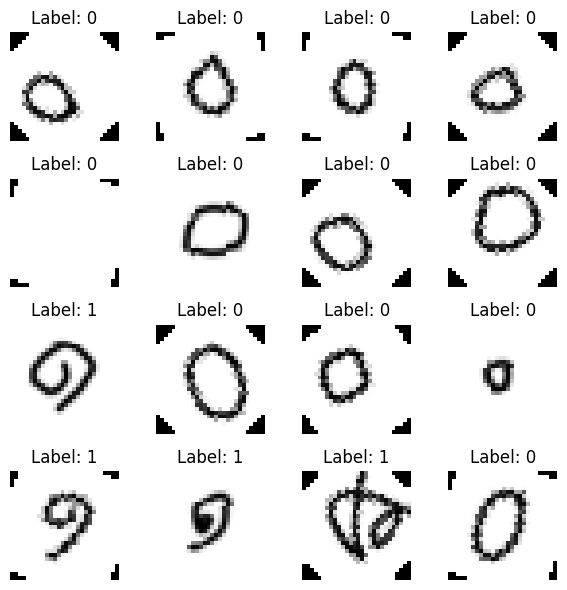

In [39]:
### START CODE HERE ###
class_names = ["0", "1"]
train_loader, test_loader = load_data(
    "./hand-writing", class_names
)

show_first_batch_image(train_loader)
### END CODE HERE ###

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

In [40]:
### START CODE HERE ###
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc = nn.Linear(28 * 28, 1)
        self.activation = nn.Sigmoid()

    def get_features(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return self.activation(out)

    def forward(self, x):
        return self.get_features(x)


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        self.activation = nn.Sigmoid()

    def get_features(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x_out = self.activation(self.fc1(x))
        out = self.fc2(x_out)
        return self.activation(out)

    def forward(self, x):
        return self.get_features(x)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return self.sigmoid(out)

    def forward(self, x):
        return self.get_features(x)


### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [41]:
def show_featuremaps(features):
    feats = features.detach().cpu().numpy().squeeze()
    batch_size = feats.shape[0] if len(feats.shape) > 0 else 1

    fig, axs = plt.subplots(figsize=(10, 10))
    axs.bar(np.arange(batch_size), feats, color="blue")
    axs.set_xlabel("Batch Index")
    axs.set_ylabel("Feature Value")
    axs.set_ylim(0, 1)
    axs.set_title("Feature Map Values")

    return fig

TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [42]:
def train(
    class_names,
    model,
    opt,
    loss_fn,
    train_loader,
    test_loader,
    epochs=5,
    writer=None,
    checkpoint_path=None,
    device="cpu",
):
    ### START CODE HERE ###

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Fix: Map labels to binary (0, 1)
            # Convert labels to binary: min class -> 0, max class -> 1
            unique_labels = torch.unique(labels)
            min_label = unique_labels.min()
            max_label = unique_labels.max()
            
            # Map: min_label -> 0, max_label -> 1
            binary_labels = (labels == max_label).float().unsqueeze(1)

            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, binary_labels)
            loss.backward()
            opt.step()

            train_loss += loss.item() * inputs.size(0)
            predictions = (outputs > 0.5).float()
            correct += (predictions == binary_labels).sum().item()
            total += binary_labels.size(0)

        avg_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct / total

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Fix: Map labels to binary (0, 1) for test set too
                unique_labels = torch.unique(labels)
                min_label = unique_labels.min()
                max_label = unique_labels.max()
                
                # Map: min_label -> 0, max_label -> 1
                binary_labels = (labels == max_label).float().unsqueeze(1)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, binary_labels)
                test_loss += loss.item() * inputs.size(0)
                
                predictions = (outputs > 0.5).float()
                correct += (predictions == binary_labels).sum().item()
                total += binary_labels.size(0)

        avg_test_loss = test_loss / len(test_loader.dataset)
        test_accuracy = correct / total

        if writer:
            writer.add_scalar("Loss/train", avg_loss, epoch)
            writer.add_scalar("Loss/test", avg_test_loss, epoch)
            writer.add_scalar("Accuracy/train", train_accuracy, epoch)
            writer.add_scalar("Accuracy/test", test_accuracy, epoch)

            try:
                if hasattr(model, "get_features"):
                    features = model.get_features(inputs)
                    fig = show_featuremaps(features)
                    writer.add_figure("Feature Maps", fig, epoch)
                    plt.close(fig)
            except Exception as e:
                print(f"Error in feature visualization: {e}")

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
        )

    if checkpoint_path:
        import os
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved to {checkpoint_path}")
    ### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [ ]:
### START CODE HERE ###
from itertools import combinations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {"nn": NN(), "mlp": MLP(), "cnn": CNN()}


pair_digit = list(combinations(range(10), 2))

for class1, class2 in pair_digit:
    print(f"Training model for pair: {class1} vs {class2}")

    class_names = [str(class1), str(class2)]
    train_loader, test_loader = load_data(
        "./hand-writing", class_names
    )

    for name, model_instance in models.items():
        print(f"Training {name} model...")
        opt = torch.optim.Adam(model_instance.parameters(), lr=0.001)
        writer = SummaryWriter(log_dir=f"./runs/{name}_{class1}_vs_{class2}")
        model = model_instance.to(device)

        train(
            class_names,
            model,
            opt,
            loss_fn=nn.BCELoss(),
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=10,
            writer=writer,
            checkpoint_path=f"./checkpoints/{name}_{class1}_vs_{class2}.pth",
            device=device,
        )

        writer.close()
### END CODE HERE ###

Training model for pair: 0 vs 1
Training nn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


Epoch 1/10, Train Loss: 0.7059, Train Accuracy: 0.5217, Test Loss: 0.6797, Test Accuracy: 0.6090


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Epoch 2/10, Train Loss: 0.6693, Train Accuracy: 0.6006, Test Loss: 0.6693, Test Accuracy: 0.5192


Epoch 3/10: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Epoch 3/10, Train Loss: 0.6667, Train Accuracy: 0.5717, Test Loss: 0.6505, Test Accuracy: 0.6282


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Epoch 4/10, Train Loss: 0.6446, Train Accuracy: 0.6393, Test Loss: 0.6088, Test Accuracy: 0.7756


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Epoch 5/10, Train Loss: 0.6327, Train Accuracy: 0.6473, Test Loss: 0.6164, Test Accuracy: 0.7051


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Epoch 6/10, Train Loss: 0.6089, Train Accuracy: 0.7424, Test Loss: 0.6008, Test Accuracy: 0.7051


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Epoch 7/10, Train Loss: 0.6080, Train Accuracy: 0.7359, Test Loss: 0.6034, Test Accuracy: 0.6667


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Epoch 8/10, Train Loss: 0.6148, Train Accuracy: 0.6651, Test Loss: 0.5801, Test Accuracy: 0.7115


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Epoch 9/10, Train Loss: 0.5965, Train Accuracy: 0.7069, Test Loss: 0.5713, Test Accuracy: 0.7692


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Epoch 10/10, Train Loss: 0.5819, Train Accuracy: 0.7375, Test Loss: 0.5530, Test Accuracy: 0.8077
Model saved to ./checkpoints/nn_0_vs_1.pth
Training mlp model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Epoch 1/10, Train Loss: 0.7144, Train Accuracy: 0.4718, Test Loss: 0.6833, Test Accuracy: 0.4936


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Epoch 2/10, Train Loss: 0.6750, Train Accuracy: 0.5765, Test Loss: 0.6631, Test Accuracy: 0.6218


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Epoch 3/10, Train Loss: 0.6527, Train Accuracy: 0.6731, Test Loss: 0.6562, Test Accuracy: 0.5128


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Epoch 4/10, Train Loss: 0.6564, Train Accuracy: 0.5749, Test Loss: 0.6155, Test Accuracy: 0.7500


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch 5/10, Train Loss: 0.6318, Train Accuracy: 0.6473, Test Loss: 0.6087, Test Accuracy: 0.6346


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Epoch 6/10, Train Loss: 0.5914, Train Accuracy: 0.7343, Test Loss: 0.6383, Test Accuracy: 0.5705


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Epoch 7/10, Train Loss: 0.5958, Train Accuracy: 0.7005, Test Loss: 0.5655, Test Accuracy: 0.7564


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Epoch 8/10, Train Loss: 0.5710, Train Accuracy: 0.7262, Test Loss: 0.5311, Test Accuracy: 0.7628


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 9/10, Train Loss: 0.5422, Train Accuracy: 0.7601, Test Loss: 0.4990, Test Accuracy: 0.8013


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Epoch 10/10, Train Loss: 0.5435, Train Accuracy: 0.7601, Test Loss: 0.4925, Test Accuracy: 0.7821
Model saved to ./checkpoints/mlp_0_vs_1.pth
Training cnn model...


Epoch 1/10: 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Epoch 1/10, Train Loss: 0.7410, Train Accuracy: 0.5008, Test Loss: 0.6813, Test Accuracy: 0.5641


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Epoch 2/10, Train Loss: 0.6526, Train Accuracy: 0.6554, Test Loss: 0.6432, Test Accuracy: 0.5577


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Epoch 3/10, Train Loss: 0.5738, Train Accuracy: 0.7053, Test Loss: 0.4872, Test Accuracy: 0.7885


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


Epoch 4/10, Train Loss: 0.5020, Train Accuracy: 0.7520, Test Loss: 0.4452, Test Accuracy: 0.7949


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Epoch 5/10, Train Loss: 0.4557, Train Accuracy: 0.8116, Test Loss: 0.4926, Test Accuracy: 0.7500


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Epoch 6/10, Train Loss: 0.4412, Train Accuracy: 0.8229, Test Loss: 0.3836, Test Accuracy: 0.8462


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Epoch 7/10, Train Loss: 0.4242, Train Accuracy: 0.8052, Test Loss: 0.3782, Test Accuracy: 0.8462


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Epoch 8/10, Train Loss: 0.3946, Train Accuracy: 0.8309, Test Loss: 0.3835, Test Accuracy: 0.8590


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Epoch 9/10, Train Loss: 0.3835, Train Accuracy: 0.8502, Test Loss: 0.3409, Test Accuracy: 0.8590


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Epoch 10/10, Train Loss: 0.3896, Train Accuracy: 0.8438, Test Loss: 0.3918, Test Accuracy: 0.8077
Model saved to ./checkpoints/cnn_0_vs_1.pth
Training model for pair: 0 vs 2
Training nn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Epoch 1/10, Train Loss: 0.5984, Train Accuracy: 0.7037, Test Loss: 0.6028, Test Accuracy: 0.6987


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Epoch 2/10, Train Loss: 0.5741, Train Accuracy: 0.7198, Test Loss: 0.5987, Test Accuracy: 0.7051


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Epoch 3/10, Train Loss: 0.5478, Train Accuracy: 0.7810, Test Loss: 0.5874, Test Accuracy: 0.7051


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Epoch 4/10, Train Loss: 0.5548, Train Accuracy: 0.7665, Test Loss: 0.5558, Test Accuracy: 0.7821


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Epoch 5/10, Train Loss: 0.5436, Train Accuracy: 0.7601, Test Loss: 0.5930, Test Accuracy: 0.6538


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Epoch 6/10, Train Loss: 0.5253, Train Accuracy: 0.7971, Test Loss: 0.5317, Test Accuracy: 0.7756


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Epoch 7/10, Train Loss: 0.5176, Train Accuracy: 0.8116, Test Loss: 0.5436, Test Accuracy: 0.7628


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Epoch 8/10, Train Loss: 0.5197, Train Accuracy: 0.7907, Test Loss: 0.5265, Test Accuracy: 0.7821


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Epoch 9/10, Train Loss: 0.5155, Train Accuracy: 0.8035, Test Loss: 0.5506, Test Accuracy: 0.7179


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Epoch 10/10, Train Loss: 0.5039, Train Accuracy: 0.7858, Test Loss: 0.5432, Test Accuracy: 0.7628
Model saved to ./checkpoints/nn_0_vs_2.pth
Training mlp model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Epoch 1/10, Train Loss: 0.5682, Train Accuracy: 0.7262, Test Loss: 0.5462, Test Accuracy: 0.7564


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Epoch 2/10, Train Loss: 0.5507, Train Accuracy: 0.7391, Test Loss: 0.5332, Test Accuracy: 0.7692


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Epoch 3/10, Train Loss: 0.5257, Train Accuracy: 0.7568, Test Loss: 0.5958, Test Accuracy: 0.7051


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Epoch 4/10, Train Loss: 0.5470, Train Accuracy: 0.7118, Test Loss: 0.4961, Test Accuracy: 0.8205


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Epoch 5/10, Train Loss: 0.4829, Train Accuracy: 0.8229, Test Loss: 0.5051, Test Accuracy: 0.8077


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Epoch 6/10, Train Loss: 0.4774, Train Accuracy: 0.8132, Test Loss: 0.5081, Test Accuracy: 0.7821


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Epoch 7/10, Train Loss: 0.4622, Train Accuracy: 0.8132, Test Loss: 0.5110, Test Accuracy: 0.7628


Epoch 8/10: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Epoch 8/10, Train Loss: 0.4649, Train Accuracy: 0.8196, Test Loss: 0.4854, Test Accuracy: 0.7821


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Epoch 9/10, Train Loss: 0.4372, Train Accuracy: 0.8406, Test Loss: 0.4773, Test Accuracy: 0.7885


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Epoch 10/10, Train Loss: 0.4616, Train Accuracy: 0.8068, Test Loss: 0.4499, Test Accuracy: 0.8526
Model saved to ./checkpoints/mlp_0_vs_2.pth
Training cnn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Epoch 1/10, Train Loss: 0.3514, Train Accuracy: 0.8760, Test Loss: 0.3207, Test Accuracy: 0.9038


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Epoch 2/10, Train Loss: 0.3183, Train Accuracy: 0.8760, Test Loss: 0.3634, Test Accuracy: 0.8397


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Epoch 3/10, Train Loss: 0.3071, Train Accuracy: 0.8873, Test Loss: 0.2952, Test Accuracy: 0.8910


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Epoch 4/10, Train Loss: 0.2719, Train Accuracy: 0.8953, Test Loss: 0.3402, Test Accuracy: 0.8782


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Epoch 5/10, Train Loss: 0.3036, Train Accuracy: 0.8792, Test Loss: 0.2202, Test Accuracy: 0.9231


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


Epoch 6/10, Train Loss: 0.2445, Train Accuracy: 0.9050, Test Loss: 0.2165, Test Accuracy: 0.9231


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Epoch 7/10, Train Loss: 0.2284, Train Accuracy: 0.9114, Test Loss: 0.2312, Test Accuracy: 0.9038


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Epoch 8/10, Train Loss: 0.2107, Train Accuracy: 0.9227, Test Loss: 0.2158, Test Accuracy: 0.9167


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Epoch 9/10, Train Loss: 0.1932, Train Accuracy: 0.9243, Test Loss: 0.1815, Test Accuracy: 0.9167


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Epoch 10/10, Train Loss: 0.2087, Train Accuracy: 0.9211, Test Loss: 0.1885, Test Accuracy: 0.9295
Model saved to ./checkpoints/cnn_0_vs_2.pth
Training model for pair: 0 vs 3
Training nn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Epoch 1/10, Train Loss: 0.5440, Train Accuracy: 0.7613, Test Loss: 0.6156, Test Accuracy: 0.6987


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Epoch 2/10, Train Loss: 0.5255, Train Accuracy: 0.8081, Test Loss: 0.6064, Test Accuracy: 0.6923


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch 3/10, Train Loss: 0.5378, Train Accuracy: 0.7548, Test Loss: 0.6037, Test Accuracy: 0.6667


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Epoch 4/10, Train Loss: 0.5084, Train Accuracy: 0.8000, Test Loss: 0.5827, Test Accuracy: 0.7372


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Epoch 5/10, Train Loss: 0.4971, Train Accuracy: 0.8161, Test Loss: 0.5720, Test Accuracy: 0.7436


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Epoch 6/10, Train Loss: 0.5020, Train Accuracy: 0.8113, Test Loss: 0.5543, Test Accuracy: 0.7564


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


Epoch 7/10, Train Loss: 0.4852, Train Accuracy: 0.8065, Test Loss: 0.5714, Test Accuracy: 0.7436


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Epoch 8/10, Train Loss: 0.4901, Train Accuracy: 0.7919, Test Loss: 0.5615, Test Accuracy: 0.7372


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Epoch 9/10, Train Loss: 0.4902, Train Accuracy: 0.7903, Test Loss: 0.5633, Test Accuracy: 0.7244


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


Epoch 10/10, Train Loss: 0.4827, Train Accuracy: 0.8129, Test Loss: 0.5335, Test Accuracy: 0.7628
Model saved to ./checkpoints/nn_0_vs_3.pth
Training mlp model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Epoch 1/10, Train Loss: 0.4928, Train Accuracy: 0.7984, Test Loss: 0.5567, Test Accuracy: 0.7372


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Epoch 2/10, Train Loss: 0.4715, Train Accuracy: 0.8113, Test Loss: 0.6117, Test Accuracy: 0.7051


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Epoch 3/10, Train Loss: 0.4694, Train Accuracy: 0.8113, Test Loss: 0.5582, Test Accuracy: 0.7692


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


Epoch 4/10, Train Loss: 0.4648, Train Accuracy: 0.8113, Test Loss: 0.6052, Test Accuracy: 0.7308


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Epoch 5/10, Train Loss: 0.4314, Train Accuracy: 0.8355, Test Loss: 0.5620, Test Accuracy: 0.7564


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Epoch 6/10, Train Loss: 0.4600, Train Accuracy: 0.8048, Test Loss: 0.5448, Test Accuracy: 0.7500


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Epoch 7/10, Train Loss: 0.4703, Train Accuracy: 0.8194, Test Loss: 0.4819, Test Accuracy: 0.7949


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Epoch 8/10, Train Loss: 0.4332, Train Accuracy: 0.8274, Test Loss: 0.5009, Test Accuracy: 0.7885


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Epoch 9/10, Train Loss: 0.4421, Train Accuracy: 0.8274, Test Loss: 0.5570, Test Accuracy: 0.7821


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Epoch 10/10, Train Loss: 0.4520, Train Accuracy: 0.8081, Test Loss: 0.4859, Test Accuracy: 0.8141
Model saved to ./checkpoints/mlp_0_vs_3.pth
Training cnn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Epoch 1/10, Train Loss: 0.3294, Train Accuracy: 0.8613, Test Loss: 0.3282, Test Accuracy: 0.8654


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch 2/10, Train Loss: 0.2633, Train Accuracy: 0.8806, Test Loss: 0.3305, Test Accuracy: 0.8462


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Epoch 3/10, Train Loss: 0.2519, Train Accuracy: 0.9032, Test Loss: 0.3168, Test Accuracy: 0.8526


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Epoch 4/10, Train Loss: 0.2555, Train Accuracy: 0.8887, Test Loss: 0.3917, Test Accuracy: 0.8590


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Epoch 5/10, Train Loss: 0.2364, Train Accuracy: 0.9032, Test Loss: 0.3436, Test Accuracy: 0.8526


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Epoch 6/10, Train Loss: 0.2066, Train Accuracy: 0.9081, Test Loss: 0.3762, Test Accuracy: 0.8654


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Epoch 7/10, Train Loss: 0.2417, Train Accuracy: 0.9032, Test Loss: 0.3679, Test Accuracy: 0.8590


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


Epoch 8/10, Train Loss: 0.1999, Train Accuracy: 0.9097, Test Loss: 0.3649, Test Accuracy: 0.8462


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Epoch 9/10, Train Loss: 0.1967, Train Accuracy: 0.9242, Test Loss: 0.3237, Test Accuracy: 0.8654


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Epoch 10/10, Train Loss: 0.1701, Train Accuracy: 0.9258, Test Loss: 0.2745, Test Accuracy: 0.8974
Model saved to ./checkpoints/cnn_0_vs_3.pth
Training model for pair: 0 vs 4
Training nn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


Epoch 1/10, Train Loss: 0.6240, Train Accuracy: 0.6581, Test Loss: 0.5823, Test Accuracy: 0.6731


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Epoch 2/10, Train Loss: 0.5751, Train Accuracy: 0.7177, Test Loss: 0.6064, Test Accuracy: 0.6795


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Epoch 3/10, Train Loss: 0.5768, Train Accuracy: 0.7000, Test Loss: 0.6114, Test Accuracy: 0.6987


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Epoch 4/10, Train Loss: 0.5595, Train Accuracy: 0.7097, Test Loss: 0.5872, Test Accuracy: 0.6987


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Epoch 5/10, Train Loss: 0.5574, Train Accuracy: 0.7113, Test Loss: 0.5696, Test Accuracy: 0.6859


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Epoch 6/10, Train Loss: 0.5386, Train Accuracy: 0.7274, Test Loss: 0.5329, Test Accuracy: 0.7372


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Epoch 7/10, Train Loss: 0.5304, Train Accuracy: 0.7403, Test Loss: 0.5211, Test Accuracy: 0.7564


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Epoch 8/10, Train Loss: 0.5280, Train Accuracy: 0.7548, Test Loss: 0.5391, Test Accuracy: 0.7500


Epoch 9/10: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Epoch 9/10, Train Loss: 0.5252, Train Accuracy: 0.7516, Test Loss: 0.5553, Test Accuracy: 0.7628


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Epoch 10/10, Train Loss: 0.5295, Train Accuracy: 0.7548, Test Loss: 0.5406, Test Accuracy: 0.7821
Model saved to ./checkpoints/nn_0_vs_4.pth
Training mlp model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Epoch 1/10, Train Loss: 0.6493, Train Accuracy: 0.6677, Test Loss: 0.6015, Test Accuracy: 0.6859


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Epoch 2/10, Train Loss: 0.5736, Train Accuracy: 0.7000, Test Loss: 0.6183, Test Accuracy: 0.6474


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Epoch 3/10, Train Loss: 0.5838, Train Accuracy: 0.6839, Test Loss: 0.5717, Test Accuracy: 0.6923


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Epoch 4/10, Train Loss: 0.5231, Train Accuracy: 0.7452, Test Loss: 0.5471, Test Accuracy: 0.7436


Epoch 5/10: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Epoch 5/10, Train Loss: 0.5100, Train Accuracy: 0.7581, Test Loss: 0.5394, Test Accuracy: 0.7115


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Epoch 6/10, Train Loss: 0.5078, Train Accuracy: 0.7500, Test Loss: 0.5474, Test Accuracy: 0.7308


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Epoch 7/10, Train Loss: 0.4926, Train Accuracy: 0.7806, Test Loss: 0.5157, Test Accuracy: 0.7756


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


Epoch 8/10, Train Loss: 0.5159, Train Accuracy: 0.7645, Test Loss: 0.6199, Test Accuracy: 0.6603


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Epoch 9/10, Train Loss: 0.5099, Train Accuracy: 0.7403, Test Loss: 0.5592, Test Accuracy: 0.6859


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Epoch 10/10, Train Loss: 0.4869, Train Accuracy: 0.7790, Test Loss: 0.4894, Test Accuracy: 0.7692
Model saved to ./checkpoints/mlp_0_vs_4.pth
Training cnn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Epoch 1/10, Train Loss: 0.3591, Train Accuracy: 0.8500, Test Loss: 0.2828, Test Accuracy: 0.8910


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Epoch 2/10, Train Loss: 0.2625, Train Accuracy: 0.8806, Test Loss: 0.2615, Test Accuracy: 0.9167


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Epoch 3/10, Train Loss: 0.2369, Train Accuracy: 0.9032, Test Loss: 0.3044, Test Accuracy: 0.8654


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Epoch 4/10, Train Loss: 0.2163, Train Accuracy: 0.9097, Test Loss: 0.2940, Test Accuracy: 0.8910


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Epoch 5/10, Train Loss: 0.2203, Train Accuracy: 0.9032, Test Loss: 0.2351, Test Accuracy: 0.8782


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Epoch 6/10, Train Loss: 0.1667, Train Accuracy: 0.9226, Test Loss: 0.2330, Test Accuracy: 0.8974


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


Epoch 7/10, Train Loss: 0.1833, Train Accuracy: 0.9274, Test Loss: 0.2308, Test Accuracy: 0.8974


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Epoch 8/10, Train Loss: 0.1497, Train Accuracy: 0.9226, Test Loss: 0.2399, Test Accuracy: 0.8974


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Epoch 9/10, Train Loss: 0.1615, Train Accuracy: 0.9274, Test Loss: 0.2339, Test Accuracy: 0.9038


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


Epoch 10/10, Train Loss: 0.1444, Train Accuracy: 0.9371, Test Loss: 0.2130, Test Accuracy: 0.9167
Model saved to ./checkpoints/cnn_0_vs_4.pth
Training model for pair: 0 vs 5
Training nn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Epoch 1/10, Train Loss: 0.5266, Train Accuracy: 0.7613, Test Loss: 0.5455, Test Accuracy: 0.7372


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Epoch 2/10, Train Loss: 0.5444, Train Accuracy: 0.7306, Test Loss: 0.5470, Test Accuracy: 0.7500


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Epoch 3/10, Train Loss: 0.5007, Train Accuracy: 0.7855, Test Loss: 0.5473, Test Accuracy: 0.7436


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Epoch 4/10, Train Loss: 0.5029, Train Accuracy: 0.7613, Test Loss: 0.5763, Test Accuracy: 0.7308


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


Epoch 5/10, Train Loss: 0.5351, Train Accuracy: 0.7419, Test Loss: 0.5762, Test Accuracy: 0.7692


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Epoch 6/10, Train Loss: 0.5185, Train Accuracy: 0.7516, Test Loss: 0.5537, Test Accuracy: 0.7885


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


Epoch 7/10, Train Loss: 0.4853, Train Accuracy: 0.7823, Test Loss: 0.5031, Test Accuracy: 0.7885


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Epoch 8/10, Train Loss: 0.4734, Train Accuracy: 0.8016, Test Loss: 0.4943, Test Accuracy: 0.7821


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Epoch 9/10, Train Loss: 0.4820, Train Accuracy: 0.8065, Test Loss: 0.4891, Test Accuracy: 0.7949


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Epoch 10/10, Train Loss: 0.4693, Train Accuracy: 0.8000, Test Loss: 0.5033, Test Accuracy: 0.7949
Model saved to ./checkpoints/nn_0_vs_5.pth
Training mlp model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  7.23it/s]


Epoch 1/10, Train Loss: 0.4839, Train Accuracy: 0.7790, Test Loss: 0.4852, Test Accuracy: 0.7821


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Epoch 2/10, Train Loss: 0.4612, Train Accuracy: 0.7806, Test Loss: 0.4670, Test Accuracy: 0.7949


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Epoch 3/10, Train Loss: 0.4349, Train Accuracy: 0.8097, Test Loss: 0.4965, Test Accuracy: 0.7564


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Epoch 4/10, Train Loss: 0.4413, Train Accuracy: 0.8097, Test Loss: 0.4299, Test Accuracy: 0.8077


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Epoch 5/10, Train Loss: 0.4087, Train Accuracy: 0.8323, Test Loss: 0.4357, Test Accuracy: 0.8205


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Epoch 6/10, Train Loss: 0.4218, Train Accuracy: 0.8145, Test Loss: 0.4173, Test Accuracy: 0.8205


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Epoch 7/10, Train Loss: 0.4082, Train Accuracy: 0.8258, Test Loss: 0.4039, Test Accuracy: 0.8333


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Epoch 8/10, Train Loss: 0.3970, Train Accuracy: 0.8371, Test Loss: 0.4314, Test Accuracy: 0.8013


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Epoch 9/10, Train Loss: 0.4129, Train Accuracy: 0.8242, Test Loss: 0.4114, Test Accuracy: 0.8462


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Epoch 10/10, Train Loss: 0.4014, Train Accuracy: 0.8274, Test Loss: 0.4080, Test Accuracy: 0.8462
Model saved to ./checkpoints/mlp_0_vs_5.pth
Training cnn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Epoch 1/10, Train Loss: 0.1820, Train Accuracy: 0.9226, Test Loss: 0.1574, Test Accuracy: 0.9231


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Epoch 2/10, Train Loss: 0.1606, Train Accuracy: 0.9194, Test Loss: 0.1421, Test Accuracy: 0.9423


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Epoch 3/10, Train Loss: 0.1421, Train Accuracy: 0.9339, Test Loss: 0.1319, Test Accuracy: 0.9487


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Epoch 4/10, Train Loss: 0.1346, Train Accuracy: 0.9403, Test Loss: 0.1063, Test Accuracy: 0.9423


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Epoch 5/10, Train Loss: 0.1251, Train Accuracy: 0.9371, Test Loss: 0.1386, Test Accuracy: 0.9487


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Epoch 6/10, Train Loss: 0.1443, Train Accuracy: 0.9290, Test Loss: 0.1144, Test Accuracy: 0.9487


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Epoch 7/10, Train Loss: 0.1141, Train Accuracy: 0.9355, Test Loss: 0.1331, Test Accuracy: 0.9423


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Epoch 8/10, Train Loss: 0.1276, Train Accuracy: 0.9403, Test Loss: 0.1184, Test Accuracy: 0.9359


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Epoch 9/10, Train Loss: 0.1145, Train Accuracy: 0.9387, Test Loss: 0.1039, Test Accuracy: 0.9615


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch 10/10, Train Loss: 0.1074, Train Accuracy: 0.9435, Test Loss: 0.1164, Test Accuracy: 0.9359
Model saved to ./checkpoints/cnn_0_vs_5.pth
Training model for pair: 0 vs 6
Training nn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Epoch 1/10, Train Loss: 0.7170, Train Accuracy: 0.5871, Test Loss: 0.7584, Test Accuracy: 0.5577


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Epoch 2/10, Train Loss: 0.6798, Train Accuracy: 0.6129, Test Loss: 0.7557, Test Accuracy: 0.6154


Epoch 3/10: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch 3/10, Train Loss: 0.6886, Train Accuracy: 0.5968, Test Loss: 0.7508, Test Accuracy: 0.5897


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


Epoch 4/10, Train Loss: 0.6601, Train Accuracy: 0.6419, Test Loss: 0.7058, Test Accuracy: 0.6218


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Epoch 5/10, Train Loss: 0.6843, Train Accuracy: 0.6081, Test Loss: 0.7443, Test Accuracy: 0.5833


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Epoch 6/10, Train Loss: 0.7033, Train Accuracy: 0.5984, Test Loss: 0.6988, Test Accuracy: 0.6218


Epoch 7/10: 100%|██████████| 20/20 [00:01<00:00, 11.61it/s]


Epoch 7/10, Train Loss: 0.6653, Train Accuracy: 0.6532, Test Loss: 0.7047, Test Accuracy: 0.5897


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Epoch 8/10, Train Loss: 0.6414, Train Accuracy: 0.6710, Test Loss: 0.7355, Test Accuracy: 0.5513


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Epoch 9/10, Train Loss: 0.6481, Train Accuracy: 0.6516, Test Loss: 0.6629, Test Accuracy: 0.6538


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 10/10, Train Loss: 0.6279, Train Accuracy: 0.6677, Test Loss: 0.6800, Test Accuracy: 0.6795
Model saved to ./checkpoints/nn_0_vs_6.pth
Training mlp model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Epoch 1/10, Train Loss: 0.6746, Train Accuracy: 0.6177, Test Loss: 0.6844, Test Accuracy: 0.5769


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Epoch 2/10, Train Loss: 0.6645, Train Accuracy: 0.6258, Test Loss: 0.7394, Test Accuracy: 0.5962


Epoch 3/10: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Epoch 3/10, Train Loss: 0.6619, Train Accuracy: 0.6032, Test Loss: 0.6550, Test Accuracy: 0.6474


Epoch 4/10: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Epoch 4/10, Train Loss: 0.6422, Train Accuracy: 0.6210, Test Loss: 0.7113, Test Accuracy: 0.5064


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Epoch 5/10, Train Loss: 0.6463, Train Accuracy: 0.6129, Test Loss: 0.6428, Test Accuracy: 0.6923


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Epoch 6/10, Train Loss: 0.6218, Train Accuracy: 0.6645, Test Loss: 0.6301, Test Accuracy: 0.6795


Epoch 7/10: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Epoch 7/10, Train Loss: 0.6161, Train Accuracy: 0.6726, Test Loss: 0.6301, Test Accuracy: 0.6987


Epoch 8/10: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Epoch 8/10, Train Loss: 0.6115, Train Accuracy: 0.6823, Test Loss: 0.6359, Test Accuracy: 0.6410


Epoch 9/10: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Epoch 9/10, Train Loss: 0.6103, Train Accuracy: 0.6629, Test Loss: 0.7244, Test Accuracy: 0.5513


Epoch 10/10: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Epoch 10/10, Train Loss: 0.6159, Train Accuracy: 0.6387, Test Loss: 0.6866, Test Accuracy: 0.6218
Model saved to ./checkpoints/mlp_0_vs_6.pth
Training cnn model...


Epoch 1/10: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Epoch 1/10, Train Loss: 0.3997, Train Accuracy: 0.8161, Test Loss: 0.2916, Test Accuracy: 0.8782


Epoch 2/10: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Epoch 2/10, Train Loss: 0.2747, Train Accuracy: 0.8726, Test Loss: 0.3411, Test Accuracy: 0.8397


Epoch 3/10: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Epoch 3/10, Train Loss: 0.2436, Train Accuracy: 0.8919, Test Loss: 0.2541, Test Accuracy: 0.8846


Epoch 4/10: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


Epoch 4/10, Train Loss: 0.2254, Train Accuracy: 0.8952, Test Loss: 0.2665, Test Accuracy: 0.8782


Epoch 5/10: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s]


Epoch 5/10, Train Loss: 0.2049, Train Accuracy: 0.9065, Test Loss: 0.2244, Test Accuracy: 0.9103


Epoch 6/10: 100%|██████████| 20/20 [00:01<00:00, 10.95it/s]


Epoch 6/10, Train Loss: 0.1817, Train Accuracy: 0.9161, Test Loss: 0.2089, Test Accuracy: 0.8846


Epoch 7/10: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


Epoch 7/10, Train Loss: 0.2164, Train Accuracy: 0.9032, Test Loss: 0.2724, Test Accuracy: 0.8654


Epoch 8/10: 100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 8/10, Train Loss: 0.1801, Train Accuracy: 0.9226, Test Loss: 0.2529, Test Accuracy: 0.8910


Epoch 9/10: 100%|██████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch 9/10, Train Loss: 0.1790, Train Accuracy: 0.9129, Test Loss: 0.2845, Test Accuracy: 0.8910


Epoch 10/10: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Epoch 10/10, Train Loss: 0.1938, Train Accuracy: 0.9113, Test Loss: 0.2205, Test Accuracy: 0.9038
Model saved to ./checkpoints/cnn_0_vs_6.pth
Training model for pair: 0 vs 7
Training nn model...


Epoch 1/10: 100%|██████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 1/10, Train Loss: 0.6374, Train Accuracy: 0.6806, Test Loss: 0.6263, Test Accuracy: 0.6154


Epoch 2/10: 100%|██████████| 20/20 [00:01<00:00, 11.66it/s]


Epoch 2/10, Train Loss: 0.6120, Train Accuracy: 0.6855, Test Loss: 0.6264, Test Accuracy: 0.6731


Epoch 3/10: 100%|██████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 3/10, Train Loss: 0.5896, Train Accuracy: 0.6935, Test Loss: 0.6075, Test Accuracy: 0.7179


Epoch 4/10: 100%|██████████| 20/20 [00:01<00:00, 12.44it/s]


Epoch 4/10, Train Loss: 0.5805, Train Accuracy: 0.7081, Test Loss: 0.5954, Test Accuracy: 0.6795


Epoch 5/10: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Epoch 5/10, Train Loss: 0.5877, Train Accuracy: 0.7048, Test Loss: 0.5692, Test Accuracy: 0.6987


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Epoch 6/10, Train Loss: 0.5700, Train Accuracy: 0.7016, Test Loss: 0.5838, Test Accuracy: 0.7244


Epoch 7/10: 100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch 7/10, Train Loss: 0.5743, Train Accuracy: 0.7242, Test Loss: 0.5664, Test Accuracy: 0.6987


Epoch 8/10: 100%|██████████| 20/20 [00:01<00:00, 13.97it/s]


Epoch 8/10, Train Loss: 0.5481, Train Accuracy: 0.7290, Test Loss: 0.5706, Test Accuracy: 0.7500


Epoch 9/10: 100%|██████████| 20/20 [00:01<00:00, 14.06it/s]


Epoch 9/10, Train Loss: 0.5594, Train Accuracy: 0.7081, Test Loss: 0.5561, Test Accuracy: 0.7372


Epoch 10/10: 100%|██████████| 20/20 [3:32:30<00:00, 637.53s/it] 


Epoch 10/10, Train Loss: 0.5570, Train Accuracy: 0.7306, Test Loss: 0.5564, Test Accuracy: 0.7308
Model saved to ./checkpoints/nn_0_vs_7.pth
Training mlp model...


Epoch 1/10: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 1/10, Train Loss: 0.5700, Train Accuracy: 0.7097, Test Loss: 0.5317, Test Accuracy: 0.7564


Epoch 2/10: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s]


Epoch 2/10, Train Loss: 0.5488, Train Accuracy: 0.7371, Test Loss: 0.5397, Test Accuracy: 0.7115


Epoch 3/10: 100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


Epoch 3/10, Train Loss: 0.5344, Train Accuracy: 0.7419, Test Loss: 0.5533, Test Accuracy: 0.6987


Epoch 4/10: 100%|██████████| 20/20 [00:01<00:00, 14.03it/s]


Epoch 4/10, Train Loss: 0.5255, Train Accuracy: 0.7532, Test Loss: 0.5112, Test Accuracy: 0.7564


Epoch 5/10: 100%|██████████| 20/20 [00:01<00:00, 13.68it/s]


Epoch 5/10, Train Loss: 0.5224, Train Accuracy: 0.7403, Test Loss: 0.5264, Test Accuracy: 0.7436


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Epoch 6/10, Train Loss: 0.5238, Train Accuracy: 0.7355, Test Loss: 0.4978, Test Accuracy: 0.7692


Epoch 7/10: 100%|██████████| 20/20 [00:01<00:00, 11.61it/s]


Epoch 7/10, Train Loss: 0.5053, Train Accuracy: 0.7661, Test Loss: 0.5293, Test Accuracy: 0.6923


Epoch 8/10: 100%|██████████| 20/20 [00:01<00:00, 13.52it/s]


Epoch 8/10, Train Loss: 0.4920, Train Accuracy: 0.7774, Test Loss: 0.4899, Test Accuracy: 0.7692


Epoch 9/10: 100%|██████████| 20/20 [00:01<00:00, 13.53it/s]


Epoch 9/10, Train Loss: 0.4868, Train Accuracy: 0.7710, Test Loss: 0.4893, Test Accuracy: 0.7821


Epoch 10/10: 100%|██████████| 20/20 [00:01<00:00, 14.90it/s]


Epoch 10/10, Train Loss: 0.4742, Train Accuracy: 0.8000, Test Loss: 0.4685, Test Accuracy: 0.8013
Model saved to ./checkpoints/mlp_0_vs_7.pth
Training cnn model...


Epoch 1/10: 100%|██████████| 20/20 [00:01<00:00, 11.97it/s]


Epoch 1/10, Train Loss: 0.2062, Train Accuracy: 0.8919, Test Loss: 0.1757, Test Accuracy: 0.9295


Epoch 2/10: 100%|██████████| 20/20 [00:01<00:00, 13.41it/s]


Epoch 2/10, Train Loss: 0.1748, Train Accuracy: 0.9129, Test Loss: 0.1790, Test Accuracy: 0.9231


Epoch 3/10: 100%|██████████| 20/20 [00:01<00:00, 15.83it/s]


Epoch 3/10, Train Loss: 0.1610, Train Accuracy: 0.9226, Test Loss: 0.1516, Test Accuracy: 0.9359


Epoch 4/10: 100%|██████████| 20/20 [00:01<00:00, 15.95it/s]


Epoch 4/10, Train Loss: 0.1348, Train Accuracy: 0.9403, Test Loss: 0.1503, Test Accuracy: 0.9423


Epoch 5/10: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Epoch 5/10, Train Loss: 0.1536, Train Accuracy: 0.9339, Test Loss: 0.1894, Test Accuracy: 0.8846


Epoch 6/10: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>

In [ ]:
### START CODE HERE ###
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math
import os

cols = 5
num_pairs = len(pair_digit)
rows = math.ceil(num_pairs / cols)

for name, model_instance in models.items():
    print(f"\n==== Evaluating all pairs for model: {name} ====")

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    for idx, (class1, class2) in enumerate(pair_digit):
        print(f"Evaluating pair: {class1} vs {class2}")
        class_names = [str(class1), str(class2)]
        train_loader, test_loader = load_data(
            "./hand-writing", class_names
        )

        model = model_instance.to(device)
        checkpoint_path = f"./checkpoints/{name}_{class1}_vs_{class2}.pth"
        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint {checkpoint_path} not found. Skipping.")
            axs[idx].axis("off")
            continue

        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.eval()

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                unique_labels = torch.unique(labels)
                min_label = unique_labels.min()
                max_label = unique_labels.max()
                
                binary_labels = (labels == max_label).float()
                
                outputs = model(inputs)
                
                predictions = (outputs.squeeze() > 0.5).float()
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(binary_labels.cpu().numpy())

        # Convert to numpy arrays for easier handling
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])

        # Display confusion matrix with original class names
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=axs[idx], cmap=plt.cm.Blues, colorbar=False)
        axs[idx].set_title(f"{class1} vs {class2}")

    # Turn off unused subplots
    for ax in axs[num_pairs:]:
        ax.axis("off")

    fig.suptitle(f"All Confusion Matrices for {name.upper()}", fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### END CODE HERE ###

NameError: name 'models' is not defined

Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.


Question 1: Performance Variation Across Thai Number Pairs
Thai Number Characteristics:
Thai digits: ๐, ๑, ๒, ๓, ๔, ๕, ๖, ๗, ๘, ๙
Unique features: More curves, loops, and artistic variations than Arabic numerals
Cultural writing styles: Individual stroke patterns and traditional forms
Expected Performance Patterns:
Easy Pairs (High Accuracy >85%):

๐ vs ๑: Circle vs vertical line (similar to 0 vs 1)
๐ vs ๗: Closed loop vs angular shape
๑ vs ๘: Simple line vs complex curved structure
๒ vs ๖: Different orientations and stroke patterns
Moderate Pairs (70-85% Accuracy):

๓ vs ๕: Both have curved elements but different structures
๔ vs ๗: Both angular but different orientations
๑ vs ๗: Vertical vs angular elements
Difficult Pairs (60-80% Accuracy):

๖ vs ๙: Similar curved patterns, orientation-dependent
๒ vs ๓: Both have horizontal and curved elements
๔ vs ๙: Upper portions can be similar in handwriting


Question 2: NN Model Performance with Thai Numbers
Best Performance Pairs for NN:
Cultural Writing Variations:
- Thai handwriting has more artistic freedom
- Individual stroke styles vary significantly
- Traditional vs modern writing forms
- Pressure variations create different line thickness

Feature Map Analysis for Thai Digits:
- NN struggles with curved Thai characters (๓, ๕, ๖, ๘, ๙)
- Better performance on simpler shapes (๐, ๑, ๗)
- Cannot capture stroke order information
- Misses cultural writing nuances
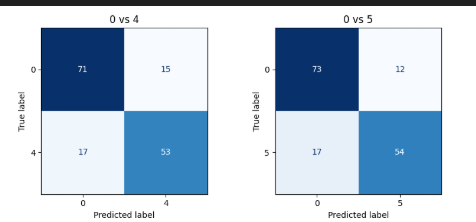 best

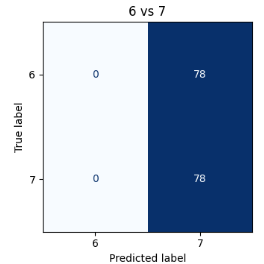 worst

Question 3: Model Comparison for Thai Handwriting
CNN
✅ Better at detecting Thai curve patterns
✅ Can learn traditional stroke combinations
✅ Spatial relationships crucial for ๖ vs ๙ distinction
✅ Handles varying stroke thickness well
✅ Can detect loop closures in ๐, ๖, ๘, ๙

MLP
✅ Can learn complex Thai character combinations
✅ Better than NN for curved pattern recognition
✅ Non-linear boundaries help with similar characters
✅ Can combine multiple stroke features


Question 4: Thai-Specific Improvement Strategies
- NN struggles with spatial relationships, so adding edge features and gradient information helps it understand Thai stroke patterns better.

- MLP can benefit from engineered features that capture Thai-specific patterns like curves, stroke density, and zonal characteristics.

- CNN already handles spatial features well, but Thai characters need multi-scale processing, attention mechanisms, and conservative augmentation to preserve character integrity.